# Alphalens package finding profolio returns

In [1]:
import alphalens as al
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
from datetime import datetime, timedelta

In [2]:
# File path to read in the data
file_path = 'data_prediction_price.csv'

# Load the file into a df
data = pd.read_csv(file_path)

# Show the first few rows of the df
data.head()

,summary,description,Ticker,adjusted_date,sentiment,positive,negative,neutral,Date,Open,High,Low,Close,Adj Close,Volume,Stock_Symbol
0,The U.S. government is investigating whether R...,The U.S. government is investigating whether R...,ROK,4/4/23,negative,0.828614,0.151855,0.019531,4/4/23,291.899994,293.140015,277.130005,278.760010,273.883362,751000,ROK
1,Norfolk Southern is being sued in a class acti...,A new class action lawsuit alleges that the co...,NSC,2/7/23,positive,0.826578,0.152356,0.021066,2/7/23,245.000000,248.509995,243.570007,247.669998,241.450394,1146600,NSC
2,The policy says that where we become aware of ...,Carol Tate was appointed CCO this year. The ch...,INTC,3/23/23,positive,0.825626,0.153743,0.020631,3/23/23,28.379999,29.160000,28.219999,29.030001,28.629633,43785500,INTC
3,"Silicon Valley Bank, founded in 1983, used fin...",SVB helped many in the venture-capital world t...,SIVBQ,6/1/23,negative,0.825235,0.149200,0.025565,6/1/23,0.380000,0.429500,0.357000,0.385000,0.385000,1106361,SIVBQ
4,Walmart CEO: American households are seeing pr...,"In some categories, double-digit inflation wil...",WMT,4/19/23,positive,0.824240,0.156578,0.019182,4/19/23,150.839996,151.410004,149.770004,150.009995,148.361908,4144500,WMT


In [3]:
# Define trading parameters
stop_loss_pct = 0.03  # The logic for direction is handled in trade calculations
take_profit_pct = 0.15
max_holding_days = 5

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date']) 

# Initialize an empty list to store trade outcomes
trades = []

# Function to calculate trade outcomes
def calculate_trade_outcome(data, row, trade_direction, sentiment_score=None):
    ticker = row['Ticker']
    entry_date = row['Date']
    entry_price = row['Open']
    
    # Adjust stop loss and take profit calculations based on trade direction
    if trade_direction == 'long':
        stop_loss_price = entry_price * (1 - stop_loss_pct)
        take_profit_price = entry_price * (1 + take_profit_pct)
    else:  # 'short'
        stop_loss_price = entry_price * (1 + stop_loss_pct)
        take_profit_price = entry_price * (1 - take_profit_pct)
    
    for i in range(1, max_holding_days + 1):
        next_day = entry_date + timedelta(days=i)
        
        if next_day in data['Date'].values:
            next_day_data = data[(data['Ticker'] == ticker) & (data['Date'] == next_day)]
            
            if not next_day_data.empty:
                exit_condition_met = False
                # For long trades, check if it hits stop loss or take profit
                if trade_direction == 'long' and (next_day_data['Low'].iloc[0] <= stop_loss_price or next_day_data['High'].iloc[0] >= take_profit_price):
                    exit_condition_met = True
                # For short trades, invert the logic
                elif trade_direction == 'short' and (next_day_data['High'].iloc[0] >= stop_loss_price or next_day_data['Low'].iloc[0] <= take_profit_price):
                    exit_condition_met = True
                
                if exit_condition_met:
                    exit_price = min(max(next_day_data['Open'].iloc[0], stop_loss_price), take_profit_price) if trade_direction == 'long' else max(min(next_day_data['Open'].iloc[0], take_profit_price), stop_loss_price)
                    profit_loss_percentage = ((exit_price - entry_price) / entry_price) * 100 * (-1 if trade_direction == 'short' else 1)
                    trades.append({'Ticker': ticker, 'Entry Date': entry_date, 'Exit Date': next_day, 'Profit/Loss %': profit_loss_percentage, 'Trade Direction': trade_direction})
                    return

    # If no exit condition is met, close the trade at the last day's close price
    if i == max_holding_days:
        last_day_data = data[(data['Ticker'] == ticker) & (data['Date'] == next_day)]
        if not last_day_data.empty:
            exit_price = last_day_data['Close'].iloc[0]
            profit_loss_percentage = ((exit_price - entry_price) / entry_price) * 100 * (-1 if trade_direction == 'short' else 1)
            trades.append({'Ticker': ticker, 'Entry Date': entry_date, 'Exit Date': next_day, 'Profit/Loss %': profit_loss_percentage, 'Trade Direction': trade_direction})

# Iterate over each row for long and short trades based on sentiment score
for index, row in data.iterrows():
    if row['sentiment'] == 'positive' and row['positive'] >= 0.77:
        calculate_trade_outcome(data, row, 'long')
    elif row['sentiment'] == 'negative' and row['negative'] >= 0.28:
        calculate_trade_outcome(data, row, 'short')

# Convert the trades list to a DataFrame for easier analysis
trades_df = pd.DataFrame(trades)

# Display the first few trades to verify
print(trades_df.head())
# Summary statistics for the trades
print(trades_df.describe())


/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_48757/1734393048.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


  Ticker Entry Date  Exit Date  Profit/Loss % Trade Direction
0    NSC 2023-04-04 2023-04-06      -3.000000            long
1   CBRE 2023-03-14 2023-03-16      -3.000000            long
2   AMZN 2023-02-24 2023-03-01      -1.454080            long
3    LYV 2023-03-20 2023-03-23       0.074956            long
4  SIVBQ 2023-05-25 2023-05-26      -3.000000            long
                          Entry Date                      Exit Date  \
count                            306                            306   
mean   2023-05-10 23:36:28.235294208  2023-05-14 06:49:24.705882368   
min              2023-01-05 00:00:00            2023-01-10 00:00:00   
25%              2023-03-20 06:00:00            2023-03-23 00:00:00   
50%              2023-05-22 12:00:00            2023-05-24 00:00:00   
75%              2023-06-21 18:00:00            2023-06-22 18:00:00   
max              2023-09-01 00:00:00            2023-09-06 00:00:00   
std                              NaN                        

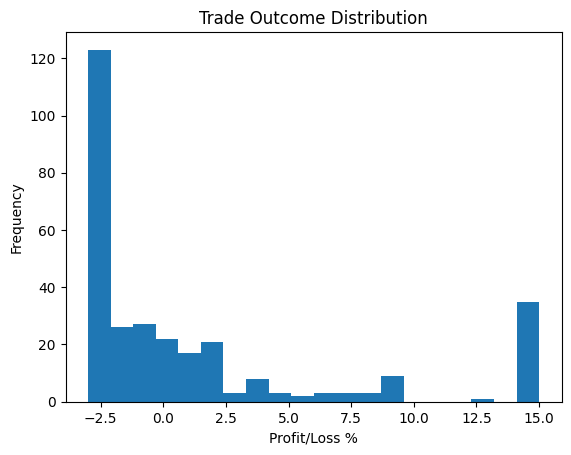

In [4]:
# let's visualize the trade outcomes
import matplotlib.pyplot as plt

# Plot the distribution of trade outcomes
plt.hist(trades_df['Profit/Loss %'], bins=20)
plt.xlabel('Profit/Loss %')
plt.ylabel('Frequency')
plt.title('Trade Outcome Distribution')
plt.show()


In [6]:
# Initial portfolio capital
initial_capital = 100000  # Example starting capital

# Current capital, starts with initial capital
current_capital = initial_capital

# Iterate over each trade in the trades list to update current capital based on profit/loss %
for trade in trades:
    profit_loss = trade['Profit/Loss %']
    # Calculate the trade outcome on the current capital
    trade_outcome = current_capital * (profit_loss / 100)
    # Update current capital
    current_capital += trade_outcome

# Calculate the total return as a percentage
total_return_percent = ((current_capital - initial_capital) / initial_capital) * 100

print(f"Initial Capital: ${initial_capital}")
print(f"Final Capital: ${current_capital:.2f}")
print(f"Total Return: {total_return_percent:.2f}%")


Initial Capital: $100000
Final Capital: $3232193.00
Total Return: 3132.19%


In [14]:
initial_portfolio_size = 10000  # Initial portfolio size
portfolio_size = initial_portfolio_size  # Portfolio size will update with each trade

# Assuming 'trades' is the list of trades from previous steps
corrected_trades = []
win_count = 0  # Count of profitable trades

for trade in trades:
    entry_price = trade['Entry Price']
    exit_price = trade['Exit Price']
    trade_direction = trade['Trade Direction']
    
    # Calculate profit/loss percentage based on trade direction
    if trade_direction == 'long':
        profit_loss_pct = ((exit_price - entry_price) / entry_price) * 100
    else:  # 'short'
        profit_loss_pct = ((entry_price - exit_price) / entry_price) * 100
    
    # Update portfolio size based on the outcome of the trade
    trade_outcome = portfolio_size * (profit_loss_pct / 100)
    portfolio_size += trade_outcome
    
    # Record the corrected trade with its outcome
    corrected_trade = trade.copy()
    corrected_trade['Profit/Loss %'] = profit_loss_pct
    corrected_trade['Trade Outcome'] = trade_outcome
    corrected_trades.append(corrected_trade)
    
    # Update win count
    if trade_outcome > 0:
        win_count += 1

# Convert the corrected trades list to a DataFrame for easier analysis
corrected_trades_df = pd.DataFrame(corrected_trades)

# Calculate analysis metrics
total_return = portfolio_size - initial_portfolio_size
total_return_pct = (total_return / initial_portfolio_size) * 100
average_return_per_trade = corrected_trades_df['Trade Outcome'].mean()
win_rate = (win_count / len(trades)) * 100

print(f"Initial Portfolio Size: ${initial_portfolio_size}")
print(f"Final Portfolio Size: ${portfolio_size:.2f}")
print(f"Total Return: ${total_return:.2f} ({total_return_pct:.2f}%)")
print(f"Average Return per Trade: ${average_return_per_trade:.2f}")
print(f"Win Rate: {win_rate:.2f}%")


KeyError: 'Entry Price'

In [3]:
df = data
df = df[['Ticker', 'adjusted_date', 'positive']]
df.head()


,Ticker,adjusted_date,positive
0,CVS,2023-01-03,0.786601
1,BLK,2023-01-03,0.802762
2,CI,2023-01-03,0.768271
3,NSC,2023-01-03,0.803227
4,NSC,2023-01-03,0.749967


In [4]:
df['adjusted_date'] = pd.to_datetime(df['adjusted_date'], utc=True)
df['adjusted_date'] = df['adjusted_date'].dt.date

print(df['adjusted_date'].dtypes)

replacements = {
    'ABC': 'ABG',
    'FRC': 'FRCB',
    'SIVB': 'SIVBQ'
}

df['Ticker'] = df['Ticker'].replace(replacements)

df

object


,Ticker,adjusted_date,positive
0,CVS,2023-01-03,0.786601
1,BLK,2023-01-03,0.802762
2,CI,2023-01-03,0.768271
3,NSC,2023-01-03,0.803227
4,NSC,2023-01-03,0.749967
...,...,...,...
3249,FRCB,2023-09-06,0.774361
3250,PM,2023-09-06,0.794666
3251,MSFT,2023-09-06,0.756086
3252,AXP,2023-09-06,0.786300


In [5]:
aggregated_data = df.groupby(['Ticker', 'adjusted_date'])['positive'].mean().reset_index()
aggregated_data

,Ticker,adjusted_date,positive
0,AAL,2023-01-11,0.780043
1,AAL,2023-02-02,0.784336
2,AAL,2023-02-23,0.798114
3,AAL,2023-03-03,0.761997
4,AAL,2023-03-13,0.789641
...,...,...,...
2490,XYL,2023-04-05,0.700859
2491,YUM,2023-03-17,0.762401
2492,YUM,2023-04-14,0.785988
2493,ZBH,2023-01-18,0.801582


In [6]:
aggregated_data['adjusted_date'] = pd.to_datetime(aggregated_data['adjusted_date']).dt.tz_localize('UTC')

# Set the MultiIndex with 'pubDate' and 'Ticker'
aggregated_data.set_index(['adjusted_date', 'Ticker'], inplace=True)

aggregated_data

,,positive
adjusted_date,Ticker,
2023-01-11 00:00:00+00:00,AAL,0.780043
2023-02-02 00:00:00+00:00,AAL,0.784336
2023-02-23 00:00:00+00:00,AAL,0.798114
2023-03-03 00:00:00+00:00,AAL,0.761997
2023-03-13 00:00:00+00:00,AAL,0.789641
...,...,...
2023-04-05 00:00:00+00:00,XYL,0.700859
2023-03-17 00:00:00+00:00,YUM,0.762401
2023-04-14 00:00:00+00:00,YUM,0.785988


In [7]:
tickers = aggregated_data.index.get_level_values('Ticker').unique()
start_date = aggregated_data.index.get_level_values('adjusted_date').min()
end_date = aggregated_data.index.get_level_values('adjusted_date').max() + pd.Timedelta(days=40)  # Extending for forward return calculation

# Fetching adjusted close prices for all tickers
prices = pd.DataFrame()
for ticker in tickers:
    ticker_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']
    prices[ticker] = ticker_data

prices.index = prices.index.tz_localize('UTC')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [68]:
prices

,AAL,AAPL,ABBV,ABG.BE,ABT,ACN,ADBE,ADI,ADM,AEP,...,WMB,WMT,WRK,WYNN,XEL,XOM,XYL,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03 00:00:00+00:00,12.74,124.216293,154.597809,151.690536,106.914360,265.065399,336.920013,159.414185,86.800789,90.119865,...,30.426344,141.442612,34.025616,84.742325,67.752022,102.045219,109.337975,124.615280,126.299927,45.668644
2023-01-04 00:00:00+00:00,13.59,125.497498,155.845047,151.258118,108.504700,264.163055,341.410004,162.809555,83.644394,90.737312,...,30.615620,141.600204,34.888721,89.978714,68.332176,102.342216,109.170151,126.303497,127.470848,47.336693
2023-01-05 00:00:00+00:00,13.99,124.166641,155.654602,149.037216,108.104683,257.925323,328.440002,156.705780,81.553047,89.084450,...,30.303314,141.117569,33.939308,90.414253,66.949478,104.632034,106.070465,125.341606,125.109177,46.507381
2023-01-06 00:00:00+00:00,14.18,128.735229,158.567963,151.395721,109.597458,264.035583,332.750000,162.426834,83.218376,91.696747,...,30.814360,144.574829,35.224377,92.621651,68.931664,105.896690,109.841423,127.883774,124.732094,48.307362
2023-01-09 00:00:00+00:00,14.61,129.261627,153.912338,151.317093,109.421837,268.488312,341.980011,163.977310,82.656815,93.045639,...,30.880608,142.772324,35.147655,93.373947,69.598846,103.923050,110.354744,127.363564,125.079407,48.081188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09 00:00:00+00:00,12.24,178.526703,146.235107,170.374527,95.764687,309.590790,529.289978,172.507187,72.756630,72.001770,...,33.930500,155.263336,35.848522,92.580208,57.168427,108.902794,90.792847,118.350197,110.469650,33.211788
2023-10-10 00:00:00+00:00,12.26,177.928253,146.019348,173.013351,96.556450,309.898376,532.719971,175.144760,73.002762,72.558929,...,33.989750,157.016830,36.409733,93.495369,57.575001,108.441338,91.650040,119.803322,111.966660,34.336117
2023-10-11 00:00:00+00:00,12.48,179.334595,146.460663,173.945892,91.687065,311.402893,549.909973,174.099670,72.559723,73.585297,...,34.256374,157.644501,36.705109,94.231476,58.318737,104.553360,92.068680,117.822685,105.140274,34.854290


In [8]:
# Filter 'aggregated_data' to only include dates that exist in 'prices
common_dates = aggregated_data.index.get_level_values('adjusted_date').intersection(prices.index)
aggregated_data_filtered = aggregated_data.loc[common_dates]

In [9]:
prices_reindexed = prices.reindex(aggregated_data_filtered.index.get_level_values('adjusted_date').unique(), method='ffill')

In [10]:
print(aggregated_data_filtered.index.get_level_values('adjusted_date').unique())
print(prices_reindexed.index)

DatetimeIndex(['2023-01-11 00:00:00+00:00', '2023-02-02 00:00:00+00:00',
               '2023-02-23 00:00:00+00:00', '2023-03-03 00:00:00+00:00',
               '2023-03-13 00:00:00+00:00', '2023-03-17 00:00:00+00:00',
               '2023-03-21 00:00:00+00:00', '2023-03-22 00:00:00+00:00',
               '2023-04-18 00:00:00+00:00', '2023-05-11 00:00:00+00:00',
               ...
               '2023-07-25 00:00:00+00:00', '2023-08-21 00:00:00+00:00',
               '2023-07-14 00:00:00+00:00', '2023-07-17 00:00:00+00:00',
               '2023-08-01 00:00:00+00:00', '2023-01-23 00:00:00+00:00',
               '2023-06-12 00:00:00+00:00', '2023-05-12 00:00:00+00:00',
               '2023-03-06 00:00:00+00:00', '2023-06-07 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='adjusted_date', length=170, freq=None)
DatetimeIndex(['2023-01-11 00:00:00+00:00', '2023-02-02 00:00:00+00:00',
               '2023-02-23 00:00:00+00:00', '2023-03-03 00:00:00+00:00',
               '

In [17]:
aggregated_data_filtered.index = pd.MultiIndex.from_tuples(aggregated_data_filtered.index)


In [11]:
aggregated_data_filtered = aggregated_data_filtered.reset_index()
if 'adjusted_date' in aggregated_data_filtered.columns:
    aggregated_data_filtered = aggregated_data_filtered.set_index('adjusted_date')
else:
    print("Column 'adjusted_date' does not exist in the DataFrame.")

# calculate forward returns
aggregated_data_filtered['1D'] = aggregated_data_filtered.groupby('Ticker')['positive'].shift(-1)
aggregated_data_filtered['5D'] = aggregated_data_filtered.groupby('Ticker')['positive'].shift(-5)
aggregated_data_filtered['10D'] = aggregated_data_filtered.groupby('Ticker')['positive'].shift(-10)

aggregated_data_filtered


,Ticker,positive,1D,5D,10D
adjusted_date,,,,,
2023-01-11 00:00:00+00:00,AAL,0.780043,0.784336,0.762688,0.753658
2023-01-11 00:00:00+00:00,ATO,0.751955,0.743069,0.801656,0.779379
2023-01-11 00:00:00+00:00,CAH,0.753701,0.733518,0.766457,NaN
2023-01-11 00:00:00+00:00,CZR,0.797641,0.753378,0.784308,0.775149
2023-01-11 00:00:00+00:00,DAL,0.768321,0.765266,0.769855,0.722524
...,...,...,...,...,...
2023-03-06 00:00:00+00:00,RL,0.771461,NaN,NaN,NaN
2023-03-06 00:00:00+00:00,UPS,0.794582,NaN,NaN,NaN
2023-03-06 00:00:00+00:00,VLO,0.794426,NaN,NaN,NaN
